## Introduction to Submodular Optimization
Author: Jacob Schreiber <jmschreiber91@gmail.com>

The amount of collected data in the world is dramatically increasing every year. Naturally, this increase has spurred the training of ever-more complex machine learning models with millions to billions of trainable parameters that have redefined state-of-the-art performance across fields. We can see the effect of these models everywhere in our life, from natural language processing models that translate text for us in our phones to computer vision models that will be a critical component of self-driving cars and adding more filters to our selfies.

However, to process this data, a corresponding increasing in the amount of computing power is usually necessary to yield meaningful results. In some cases the additional computational burden can be mitigated with parallelized versions of algorithms that are distributed across massive clusters, but pocket-sized massive clusters aren't yet available for the masses, and so these problems remain difficult for most.

Submodular optimization provides an approach for reducing the computational load of handling large data sets. The key idea is that as the size of data sets grow, generally so too does the redundancy, and the redundant examples do not provide much benefit. In this approach, the selection of a non-redundant subset of elements is treated explicitly as an optimization problem. Then, this subset can be used in the place of the large data set. Because the subset still maintains the diversity seen in the original data set, it can be used for tasks such as training accurate machine learning models. 

In several key ways, submodular optimization is similar to optimization performed on convex models (or convex approximations of non-covex models, such as deep neural networks). A user first defines a submodular function (with properties we will discuss later) that measures some notion of redundancy among a set of items, in an analogous manner to defining a layer/model. Then, the user selects an optimization approach to use, just as one would choose among SGD, ADAM, AdaDelta, etc. Finally, when given a data set, the optimization approach is guided by the scores returned by the function to build a non-redundant subset. 

Apricot implements a variety of submodular functions and optimization approaches. These functions include set cover, facility location, feature based, entropy, and graph cut. The optimizations include both greedy algorithms such as naive and lazy greedy as well as approximations of the greedy algorithm such as approximate lazy, stochastic, and GreeDi.

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy
numpy.random.seed(0)

import seaborn; seaborn.set_style('whitegrid')
from tqdm import tqdm_notebook as tqdm

### Max (Set) Coverage

The maximum coverage problem refers to the selection of $k$ elements that are each described by a set of numbers such that the union of these sets has the maximal size. Phrased differently, when applied to binary data, the maximum coverage problem refers to the selection of $k$ elements such that the most columns have at least one element with a non-zero value. Formally, this problem is 

\begin{equation}
f(X) = \sum\limits_{i=1}^{d} \left(\left( \sum\limits_{x \in X} x_{i} \right) > 0 \right)
\end{equation}
where $f$ denotes the maximum coverage function, $X$ is the set of selected examples and $d$ is the number of dimensions in the data. 

Let's take a look at an example of optimizing this function over the Reuters data set; a collection of ~11k articles where each example contains the set of indices of words in the article. We preprocess the data to be a binary matrix of size ~11k by 5k, where the 5k dimensions correspond to the presence of the top 5k words by count. 

In [72]:
from apricot import FeatureBasedSelection
from keras.datasets import reuters

(X_, _), (_, _) = reuters.load_data(num_words=5000)
X = numpy.zeros((X_.shape[0], max(map(max, X_))+1))
for i, x in enumerate(X_):
    X[i][x] = 1

We can visualize the first 250 examples from this data as a heatmap where the presence of words in the example is denoted by a green dot. Additionally, we can count the number of unique words that occur in the top randomly selected examples.

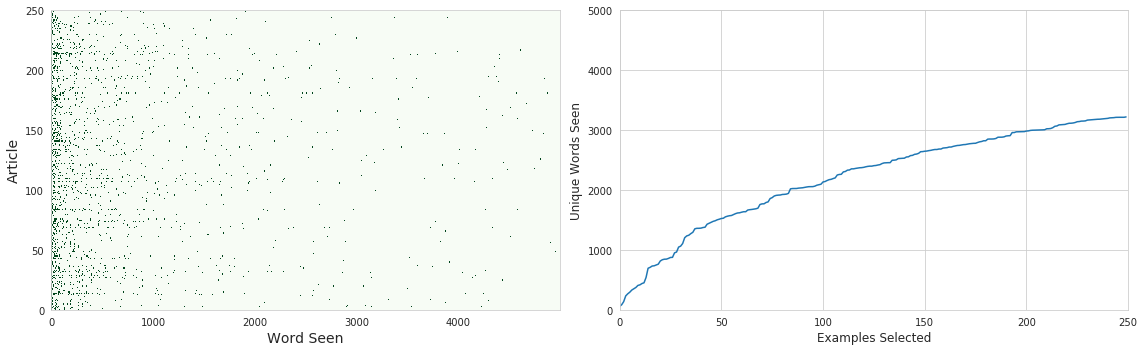

In [76]:
plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.imshow(X[:250], aspect='auto', cmap='Greens')
plt.xlabel("Word Seen", fontsize=14)
plt.ylabel("Article", fontsize=14)
plt.ylim(0, 250)
plt.grid(False)

plt.subplot(122)
plt.plot((numpy.cumsum(X[:250], axis=0) > 0).sum(axis=1))
plt.xlabel("Examples Selected", fontsize=12)
plt.ylabel("Unique Words Seen", fontsize=12)
plt.xlim(0, 250)
plt.ylim(0, 5000)

plt.tight_layout()
plt.show()

As expected, the heatmap is overall fairly sparse because most words do not occur in most articles. Randomly selecting articles seems to provide a steady increase in the number of unique words in the selected set that diminishes as more articles are added. However, even after 250 articles, there are still over 1500 words that have never been seen.

Now, let's run a max coverage selector to identify examples using submodular optimization that maximize the number of unique words seen between them.

In [74]:
model = FeatureBasedSelection(250, 'min', optimizer='naive')
X_hat = model.fit_transform(X)

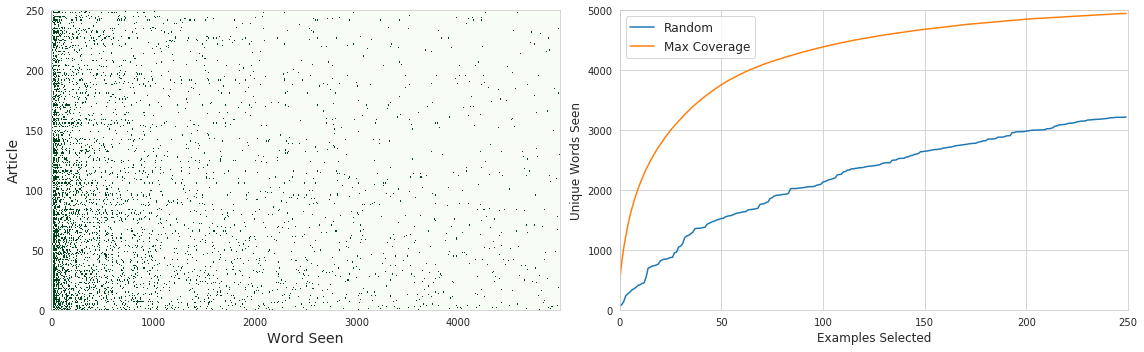

In [77]:
plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.imshow(X_hat, aspect='auto', cmap='Greens')
plt.xlabel("Word Seen", fontsize=14)
plt.ylabel("Article", fontsize=14)
plt.ylim(0, 250)
plt.grid(False)

plt.subplot(122)
plt.plot((numpy.cumsum(X[:250], axis=0) > 0).sum(axis=1), label="Random")
plt.plot((numpy.cumsum(X_hat, axis=0) > 0).sum(axis=1), label="Max Coverage")
plt.xlabel("Examples Selected", fontsize=12)
plt.ylabel("Unique Words Seen", fontsize=12)
plt.xlim(0, 250)
plt.ylim(0, 5000)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

### Facility Location

Facility location is one of the most canonical of submodular functions. This function, which operates on pairwise similarities between elements, evaluates a proposed subset of elements (exemplars) based on the maximum similarity (or minimum distance) between each element and its nearest exemplar. More formally, the function can be written as

\begin{equation}
f(X, V) = \sum\limits_{v \in V} \max\limits_{x \in X} \phi(x, v)
\end{equation}
where $f$ denotes the facility location function, $X$ is the set of exemplars, $V$ is the set of all elements (called the ground set) and $\phi$ is a non-negative measurement of similarity, such as squared correlation.

The name "facility location" comes from the problem that companies face of identifying where to, quite literally, put their next facilities. The problem is difficult because new facilities should naturally be located in places that are underserved (i.e. have high distance to their nearest exemplar) but old facilities usually cannot be moved, making traditional clustering approaches infeasible. The greedy optimization process used for submodular functions is a perfect algorithmic candidate for placing new facilities.

Let's see an example of facility location at work. We will generate 6 cluters of points, each with a different number of examples, and then select a subset of size 6 by optimizing a facility location function.

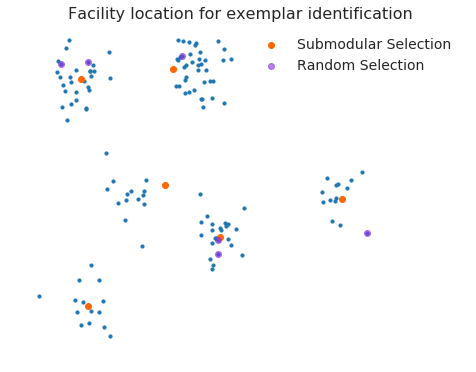

In [6]:
from apricot import FacilityLocationSelection

numpy.random.seed(0)
X = numpy.concatenate([numpy.random.normal((1, 1), 0.5, size=(15, 2)),
                       numpy.random.normal((6, 3), 0.5, size=(25, 2)),
                       numpy.random.normal((5, 7), 0.5, size=(40, 2)),
                       numpy.random.normal((1, 7), 0.5, size=(30, 2)),
                       numpy.random.normal((10, 4), 0.5, size=(15, 2)),
                       numpy.random.normal((3, 4), 0.5, size=(15, 2))])

Xi = FacilityLocationSelection(6, 'euclidean').fit_transform(X)
Xr = numpy.random.choice(numpy.arange(X.shape[0]), size=6)
Xr = X[Xr]

plt.figure(figsize=(8, 6))
plt.title("Facility location for exemplar identification", fontsize=16)
plt.scatter(X[:,0], X[:,1], s=10)
plt.scatter(Xi[:,0], Xi[:,1], color="#FF6600", label="Submodular Selection")
plt.scatter(Xr[:,0], Xr[:,1], color="#8A2BE2", label="Random Selection", alpha=0.6)
plt.legend(fontsize=14, loc=1)
plt.xlim(-1, 14)
plt.axis('off')
plt.show()

In this example an example of selecting representative points from six clusters using either a facility location function or random selection. You can see immediately that the points are more representative of the total space than a feature based function would be. A random selection of points is unlikely to sample each of the clusters only once, and this skew worsens with the skew of samples per cluster, whereas a facility location function is more stable towards that. An animation of the selection process can give some insight into how it works.

<img src="img/facilitylocation.gif">

The first selected sample is at a central location because it is representative of the full data set. In the context where facility location is actually selection store locations, this would be the optimal location to put a single store to service everyone. The second location is in the largest cluster of points but skewed towards the second largest cluster of points. At this point something interesting happens: the next selected samples seem to be central to the cluster they're selected in. The third location is at a central location in a cluster of samples that is furthest from the selected items, and thus least served. The next three points are also at the center of their respective clusters. Essentially, once the space is sparsely covered then the next selected sample can focus on serving a local neighborhood.

Facility location can be thought of as a greedy version of k-means clustering. K-means is an iterative procedure that would've resulted in the centroids lying at the center of each of the clusters above. However, it would be significantly more time intensive to calculate these. Correspondingly, facility location functions can be a good approximation of k-means clustering, and sometimes are even used as an initialization to the k-means algorithm.

#### Digits Data Set

We can use facility location for sample selection for machine learning algorithms as well. In fact, it works better than feature based methods in cases where the features do not have the nice properties seen before. Let's load up the digits data set. A feature based function would try to select samples that had a diversity of high pixel values. That's not exactly what we want because the digit can exist in several places in the image with different sizes and thicknesses.

In [7]:
from sklearn.datasets import load_digits

data = load_digits()
X, y = data.data, data.target 

idx = numpy.arange(X.shape[0])
numpy.random.shuffle(idx)

X, y = X[idx], y[idx]
X_train, y_train = X[:1250], y[:1250]
X_test, y_test = X[1250:], y[1250:]
X_train.shape, X_test.shape

((1250, 64), (547, 64))

Let's take 1,250 samples for the training set and 547 samples for the test set. We can try using a facility location function on the data that calculates the euclidean distance between samples and compare that both to random selection and to using a feature based selection algorithm. 

In [8]:
selector = FacilityLocationSelection(X_train.shape[0], 'euclidean', verbose=True)
selector.fit(X_train)
r1 = selector.ranking

selector2 = FeatureBasedSelection(X_train.shape[0], verbose=True)
selector2.fit(X_train)
r2 = selector2.ranking

  0%|          | 0/1250 [00:00<?, ?it/s]Exception KeyError: KeyError(<weakref at 0x7f120df1dd08; to 'tqdm' at 0x7f1205790c50>,) in <bound method tqdm.__del__ of   0%|          | 1/1250 [00:00<00:40, 30.81it/s]> ignored

100%|██████████| 1250/1250 [00:00<00:00, 3771.99it/s]


Now let's try training logistic regression models like before in these settings.

In [9]:
from sklearn.linear_model import LogisticRegression

numpy.random.seed(0)
random_idxs = []
for i in range(20):
    idxs = numpy.arange(X_train.shape[0])
    numpy.random.shuffle(idxs)
    random_idxs.append(idxs)

fl_acc, fb_acc, random_acc = [], [], []
n_samples = range(25, 251, 25) + range(300, 1251, 100)

for n in tqdm(n_samples):
    Xi, yi = selector.transform(X_train, y_train)
    model = LogisticRegression().fit(Xi[:n], yi[:n])
    fl_acc.append(model.score(X_test, y_test))
 
    Xi, yi = selector2.transform(X_train, y_train)
    model = LogisticRegression().fit(Xi[:n], yi[:n])
    fb_acc.append(model.score(X_test, y_test))

    accs = []
    for i in range(20):
        idx = random_idxs[i][:n]
        Xi, yi = X_train[idx], y_train[idx]

        model = LogisticRegression().fit(Xi, yi)
        accs.append(model.score(X_test, y_test))
        
    random_acc.append(accs)

random_acc = numpy.array(random_acc)

A Jupyter Widget

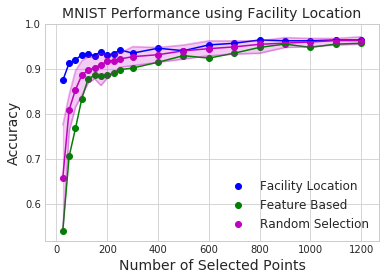

In [10]:
plt.title("MNIST Performance using Facility Location", fontsize=14)
plt.scatter(n_samples, fl_acc, c='b', label="Facility Location")
plt.scatter(n_samples, fb_acc, c='g', label="Feature Based")
plt.scatter(n_samples, random_acc.mean(axis=1), color='m', label="Random Selection")

plt.plot(n_samples, fl_acc, c='b')
plt.plot(n_samples, fb_acc, c='g')
plt.plot(n_samples, random_acc.mean(axis=1), color='m')
plt.plot(n_samples, random_acc.min(axis=1), alpha=0.3, color='m')
plt.plot(n_samples, random_acc.max(axis=1), alpha=0.3, color='m')

plt.fill_between(n_samples, random_acc.min(axis=1), random_acc.max(axis=1), color='m', alpha=0.2)
plt.xlabel("Number of Selected Points", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(fontsize=12)
plt.show()

It looks like the facility location function outperforms both the feature based function and the random selection. Similar to the case of the feature based function before the model performance appears to saturate with just a small percentage of the samples. In fact, the feature based function performs worse than the random selection. This is not surprising in the case where optimizing a diversity of features irrespective of the structure of the features may not be the best idea.

### Feature Based Submodularity

A problem with some submodular functions is that they do not scale well across massive data sets. For example, the facility location function first involves calculating some pairwise information across the data set, and second involves recalculating this pairwise measurement each time a sample is potentially added to the growing set. While optimizations exist that can greatly speed this up when compared to a naive implementation, it still can be prohibitively slow in some cases.

A different type of submodular function, called a "feature based" function, does not involve calculating pairwise information and is much more scalable to large data sets. These functions involve calculating how "saturated" a particular feature is and preferentially selecting samples that have large feature values that have not yet been seen. These function takes the following form:

\begin{equation}
f(X) = \sum\limits_{u \in U} w_{u} \phi_{u} \left( \sum\limits_{x \in X} m_{u}(x) \right)
\end{equation}

In this equation, $U$ refers to all features, or dimensions, of a sample, and $u$ refers to a specific feature. $X$ refers to the original data set that we are selecting from and $x$ refers to a single sample from that data set. $w$ is a vector of weights that indicate how important each feature is, with $w_{u}$ being a scalar referring to how important feature $u$ is. Frequently these weights are uniform. $\phi$ refers to a set of saturating functions, such as $sqrt(X)$ or $log(X + 1)$ that take some 


Feature based functions perform best when the value of each feature corresponds roughly to some notion of how important it is rather than being an arbitrary value. For example, when considering audio data, a spike in noise indicates that something is happening in an otherwise silent background, and when considering financial portfolios the more money a person has in a stock or fund, the more important that fund is for them. Examples of features where feature based functions are not likely to work well on are those without this notion, including categorical variables such as car color or bimodally distributed variables.

The reason that feature based funtions don't perform well when thre is no notion of importance can easily be visualized by looking at two Gaussian blobs. One might expect that a good summarization function would select a similar number of points from each blob, perhaps near the boundary between the two. Let's see what a feature based function does.

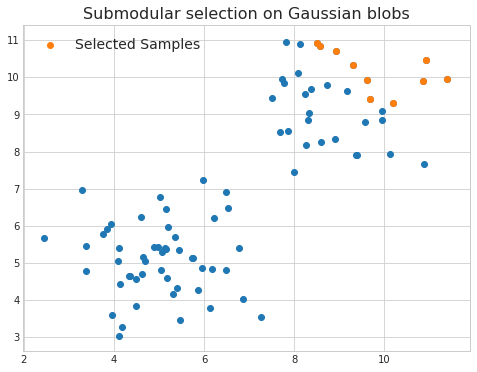

In [2]:
from apricot import FeatureBasedSelection

X = numpy.concatenate([numpy.random.normal(5, 1, size=(50, 2)), numpy.random.normal(9, 1, size=(35, 2))])
Xi = FeatureBasedSelection(10).fit_transform(X)

plt.figure(figsize=(8, 6))
plt.title("Submodular selection on Gaussian blobs", fontsize=16)
plt.scatter(X[:,0], X[:,1])
plt.scatter(Xi[:,0], Xi[:,1], label="Selected Samples")
plt.legend(fontsize=14)
plt.show()

The feature based selection chooses those samples with the highest absolute magnitude. This is not surprising because the function is trying to maximize the sum of the saturated values over each feature. You can maximize this value by always selecting the biggest values.

#### 20 newsgroups Data Set

The setting in which feature based functions perform the best is when the value of the feature corresponds to a quantity or a significance, where a higher value of that feature corresponds to having a large amount of that feature. A natural example of this is using word counts or tf-idf to represent sentences where each feature is a word. Let's see that in action here with an example from the 20newsgroups data set.

In [3]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

cats = ('sci.med', 'sci.space')
stop = ('headers', 'footers', 'quotes')

train_data = fetch_20newsgroups(subset='train', categories=cats, remove=stop)
test_data = fetch_20newsgroups(subset='test', categories=cats, remove=stop)

X_train, y_train = train_data.data, train_data.target
X_test, y_test = test_data.data, test_data.target

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

X_train.shape, X_test.shape

((1187, 1000), (790, 1000))

We've downloading 1,187 samples for our training set and 790 for our test set. This is just a toy example and so training on the entire training set is feasible, but let's see how good models trained using small subsets can perform when using random selection versus using a feature based function. We'll also perform our random selection 20 times, showing the best, worst, and average performance across the 20 times.

In [4]:
from sklearn.linear_model import LogisticRegressionCV

submodular_accuracy, random_accuracy = [], []

selection = FeatureBasedSelection(1000)
selection.fit(X_train)

numpy.random.seed(0)
random_idxs = []
for i in range(20):
    idxs = numpy.arange(X_train.shape[0])
    numpy.random.shuffle(idxs)
    random_idxs.append(idxs)

x = [20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    
for n in tqdm(x):
    Xi, yi = selection.transform(X_train, y_train)
    Xi, yi = Xi[:n], yi[:n]

    model = LogisticRegressionCV().fit(Xi, yi)
    submodular_accuracy.append(model.score(X_test, y_test))

    accs = []
    for i in range(20):
        idx = random_idxs[i][:n]
        Xi, yi = X_train[idx], y_train[idx]

        model = LogisticRegressionCV().fit(Xi, yi)
        accs.append(model.score(X_test, y_test))
        
    random_accuracy.append(accs)

random_accuracy = numpy.array(random_accuracy)

A Jupyter Widget

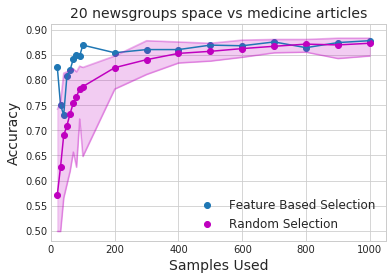

In [5]:
plt.title("20 newsgroups space vs medicine articles", fontsize=14)
plt.scatter(x, submodular_accuracy, label="Feature Based Selection")
plt.scatter(x, random_accuracy.mean(axis=1), color='m', label="Random Selection")

plt.plot(x, submodular_accuracy)
plt.plot(x, random_accuracy.mean(axis=1), color='m')
plt.plot(x, random_accuracy.min(axis=1), alpha=0.3, color='m')
plt.plot(x, random_accuracy.max(axis=1), alpha=0.3, color='m')

plt.fill_between(x, random_accuracy.min(axis=1), random_accuracy.max(axis=1), color='m', alpha=0.2)
plt.xlabel("Samples Used", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(fontsize=12)
plt.xlim(0, 1050)
plt.savefig("img/20newsgroups.png")
plt.show()

It looks like submodular selection through a feature based method distinctly outperforms using random selection for a small number of samples. Using only 100 samples selected using submodular selection one can achieve high accuracy.  